In [1]:
import numpy as np
import cv2
import pydicom
import random
from scipy.ndimage import rotate
import os
import json
import pandas as pd
from tqdm import tqdm
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import warnings
import nltk
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# Data Loading and Preprocessing

In [ ]:
!rm -rf /kaggle/working/checkpoints_20241107_123800

In [ ]:
nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')

In [ ]:
!unzip  /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora/ 

In [ ]:
nltk.data.path.append('/kaggle/working/nltk_data')

In [3]:
diseases = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema",
    "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion",
    "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

In [ ]:
import numpy as np
import cv2
import os

class ImagePreprocessor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
    
    def resize_image(self, image):
        resized_image = cv2.resize(image, self.target_size)
        return resized_image
    
    def normalize_image(self, image):
        if np.max(image) > 0:
            normalized_image = image / 255.0
        else:
            normalized_image = image
        return normalized_image
    
    def preprocess_image(self, image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")
        
        # Read the PNG image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming it's a grayscale image
        
        if image is None:
            raise ValueError(f"Error reading image: {image_path}")
        
        # Resize and normalize the image
        resized_image = self.resize_image(image)
        normalized_image = self.normalize_image(resized_image)
        
        # Add a channel dimension to match the expected input shape
        normalized_image = np.expand_dims(normalized_image, axis=0)
        
        return normalized_image

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming the ImagePreprocessor class is defined as in your previous code
preprocessor = ImagePreprocessor()

def plot_original_vs_preprocessed(png_path):
    # Load the original PNG image
    original_image = Image.open(png_path)
    original_image = np.array(original_image)  # Convert to numpy array

    # Preprocess the image
    preprocessed_image = preprocessor.preprocess_image(png_path).squeeze()  # Remove batch dimension
    print(preprocessed_image.shape)
    
    # Plotting original vs preprocessed
    plt.figure(figsize=(12, 6))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot preprocessed image
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.show()

# Example usage
png_path = '/kaggle/input/nlp-png/PNG/train/patient00021/study1/view1_frontal.png'
plot_original_vs_preprocessed(png_path)

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

# Load the consolidated CSV file
consolidated_csv_path = '/kaggle/input/radiology-report-generation-dataset-for-chest-xray/png_labels_narratives.csv'
df = pd.read_csv(consolidated_csv_path)

# Use all records in the dataset
df_sampled = df  # Using all rows directly

# Lists to store processed data
preprocessed_images = []
image_labels = []
section_impressions = []

# Preprocessor class instance
preprocessor = ImagePreprocessor()

# Process and augment the sampled images
for index, row in tqdm(df_sampled.iterrows(), desc="Processing and Augmenting Images", total=len(df_sampled)):
    png_path = row['png_path']  # Ensure this is the correct column name for PNG paths
    label_vector = row['findings']  # Assuming this is stored as a list or appropriate format in CSV
    section_impression = row['impression']  # Get the section impression

    if os.path.exists(png_path):
        try:
            # Preprocess the image with augmentation using the path
            preprocessed_image = preprocessor.preprocess_image(png_path)  # Pass the path instead

            # Convert label to array, replacing None with 0 and -1 with 0
            if isinstance(label_vector, str):
                # If the label is a string, convert it to a list of numbers
                label_vector = eval(label_vector)
            label_vector = [0 if val is None or val == -1 else val for val in label_vector]

            # Append the processed image, labels, and section impression
            preprocessed_images.append(preprocessed_image)
            image_labels.append(np.array(label_vector))
            section_impressions.append(section_impression)

        except Exception as e:
            # Handle errors if any occur while processing images
            continue  # Skip errors silently, keep processing
    else:
        continue  # Skip if the image path does not exist

In [ ]:
import pickle

# Save the arrays to a file
save_path = '/kaggle/working/preprocessed_data_v4.pkl'

with open(save_path, 'wb') as f:
    pickle.dump({
        'images': preprocessed_images,
        'labels': image_labels,
        'impressions': section_impressions
    }, f)

print(f"Data saved to {save_path}")

In [4]:
import pickle
# Load the arrays from the file
load_path = '/kaggle/working/preprocessed_data_v4.pkl'

with open(load_path, 'rb') as f:
    data = pickle.load(f)
    preprocessed_images = data['images']
    image_labels = data['labels']
    section_impressions = data['impressions']

print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
import numpy as np
from sklearn.utils import resample

# Combine your three features into a list of tuples to preserve mappings
data_tuples = list(zip(preprocessed_images, image_labels, section_impressions))

# Separate classes based on their labels
class_data = {disease: [] for disease in diseases}

# Sort the data by disease presence in labels
for image, label, impression in data_tuples:
    for i, value in enumerate(label):
        if value == 1.0:
            class_data[diseases[i]].append((image, label, impression))

# Set the target sample size (You can set it to the max class count or define your own)
target_samples = max(len(class_data[disease]) for disease in diseases if disease != 'No Finding')

# Upsample minority classes and downsample the majority class 'No Finding'
balanced_data = []

for disease in diseases:
    samples = class_data[disease]
    
    if disease == 'No Finding':
        # Downsample 'No Finding'
        downsampled_data = resample(samples, 
                                    replace=False,  # Downsample without replacement
                                    n_samples=target_samples, 
                                    random_state=42)
        balanced_data.extend(downsampled_data)
    else:
        # Upsample other diseases
        upsampled_data = resample(samples, 
                                  replace=True,  # Upsample with replacement
                                  n_samples=target_samples, 
                                  random_state=42)
        balanced_data.extend(upsampled_data)

# Shuffle the balanced dataset
np.random.shuffle(balanced_data)

# Separate back into images, labels, and impressions
balanced_images, balanced_labels, balanced_impressions = zip(*balanced_data)

# Convert them back to arrays or desired format
balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)
balanced_impressions = np.array(balanced_impressions)

print("Dataset balanced successfully.")

In [ ]:
preprocessed_images=balanced_images
image_labels=balanced_labels
section_impressions=balanced_impressions

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

def plot_random_images(image_list, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(30, 30))
    
    for i in range(num_images):
        img = random.choice(image_list)
        
        # Convert to NumPy array if img is not already one
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        
        # Check if the image has an extra channel dimension (1, 224, 224)
        if img.shape[0] == 1:
            img = img.squeeze(0)  # Remove channel dimension if it exists
        
        if num_images == 1:
            axs.imshow(img, cmap='gray')  # Assuming images are grayscale
            axs.axis('off')
        else:
            axs[i].imshow(img, cmap='gray')  # Assuming images are grayscale
            axs[i].axis('off')
    
    plt.show()

# Example usage: plot 5 random images
plot_random_images(preprocessed_images, num_images=5)

In [5]:
# Initialize a dictionary to hold the count of each disease for the balanced dataset
balanced_disease_count = {disease: 0 for disease in diseases}

# Count the number of samples for each disease in the balanced dataset
for label in image_labels:
    for i, value in enumerate(label):
        if value == 1.0:  # If the disease is present
            balanced_disease_count[diseases[i]] += 1

# Calculate the total samples in the balanced dataset
balanced_total_samples = sum(balanced_disease_count.values())
print("total sample:- ",balanced_total_samples)
# Print the result with counts and percentages for the balanced dataset
print("Counts and percentages for the balanced dataset:")
for disease, count in balanced_disease_count.items():
    percentage = (count / balanced_total_samples) * 100 if balanced_total_samples > 0 else 0
    print(f"{disease}: {count} samples ({percentage:.2f}%)")

total sample:-  77857
Counts and percentages for the balanced dataset:
Enlarged Cardiomediastinum: 3028 samples (3.89%)
Cardiomegaly: 5669 samples (7.28%)
Lung Opacity: 12703 samples (16.32%)
Lung Lesion: 2630 samples (3.38%)
Edema: 6498 samples (8.35%)
Consolidation: 3816 samples (4.90%)
Pneumonia: 2116 samples (2.72%)
Atelectasis: 4367 samples (5.61%)
Pneumothorax: 3567 samples (4.58%)
Pleural Effusion: 12101 samples (15.54%)
Pleural Other: 2040 samples (2.62%)
Fracture: 2799 samples (3.60%)
Support Devices: 14725 samples (18.91%)
No Finding: 1798 samples (2.31%)


# DataLoader preparation

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CyclicLR


In [ ]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Shape: (1, 224, 224), Min: 0.0, Max: 16.058823529411764


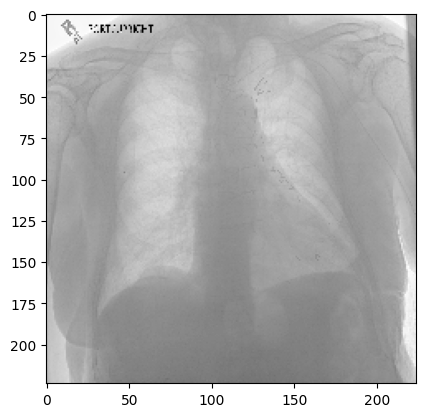

In [7]:
import matplotlib.pyplot as plt

# Choose an image from preprocessed_images
sample_image = preprocessed_images[4000]  # Pick one image for inspection

# Check if image is already in expected shape and range
print(f"Shape: {sample_image.shape}, Min: {sample_image.min()}, Max: {sample_image.max()}")

# Display the image
if sample_image.shape == (224, 224):  # Grayscale image
    plt.imshow(sample_image, cmap='gray')
elif sample_image.shape == (1, 224, 224):  # Grayscale with a single channel
    plt.imshow(sample_image.squeeze(0), cmap='gray')
else:
    raise ValueError(f"Unexpected shape: {sample_image.shape}")

plt.show()

In [ ]:
pos_weights = []

# Calculate pos_weight for each disease
for disease, count in balanced_disease_count.items():
    # pos_weight = (num_neg_samples / num_pos_samples)
    if count > 0:
        pos_weight = (balanced_total_samples - count) / count
    else:
        pos_weight = 0.0  # In case no positive samples for a disease
    pos_weights.append(pos_weight)

# Convert the pos_weights list into a tensor
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float).to(device)

# Now use this in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)

# Tokenizer (GPT2)

In [7]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

'<|endoftext|>'

# Custom Collate Function

In [9]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

In [10]:
import numpy as np
from torch.utils.data import Dataset
import torch
from PIL import Image

class MedicalImageDataset(Dataset):
    def __init__(self, images, impressions=None, transform=None, tokenizer=None):
        self.images = images  # List of preprocessed images
        self.impressions = impressions  # List of impressions (mandatory)
        self.transform = transform  # Data augmentation transform (optional)
        self.tokenizer = tokenizer  # T5 tokenizer for preprocessing text

        # Ensure impressions are provided
        if self.impressions is None:
            raise ValueError("Impressions are required but were not provided.")

        # Convert all impressions to strings, if not already
        self.impressions = [str(imp) if imp is not None else "" for imp in self.impressions]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Fetch the image and impression
        image = self.images[idx]
        impression = self.impressions[idx]

        # Convert the image to RGB if it's in grayscale
        if isinstance(image, np.ndarray):
            # Handle different grayscale shapes
            if image.ndim == 2:  # Grayscale image
                image = np.stack([image] * 3, axis=-1)  # Convert to (H, W, 3)
            elif image.ndim == 3 and image.shape[0] == 1:  # Single-channel (1, H, W)
                image = np.stack([image.squeeze(0)] * 3, axis=-1)  # Convert to (H, W, 3)
            elif image.ndim != 3 or image.shape[2] != 3:  # If not (H, W, 3)
                raise ValueError(f"Unexpected image shape: {image.shape}")

            # Scale the image values to 0-255 for uint8 conversion
            image = (image - image.min()) / (image.max() - image.min()) * 255
            image = np.clip(image, 0, 255).astype(np.uint8)
            image = Image.fromarray(image)

        # Apply transformations (e.g., normalization, augmentation) if provided
        if self.transform:
            image = self.transform(image)
        impression = f"{impression}<|endoftext|>"
        input_ids = tokenizer(
            impression,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]

        # Return image, label, and impression (input_ids and attention_mask)
        return image,input_ids,labels

In [11]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Split data
train_images, val_images, train_labels, val_labels,train_impression,val_impression = train_test_split(
    preprocessed_images,
    image_labels,
    section_impressions,
    test_size=0.2, 
    random_state=42
)

train_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor after augmentation
#     transforms.RandomAffine(degrees=(-5, 5), scale=(0.9, 1.1)),
#     transforms.RandomResizedCrop((224, 224)),
    #transforms.Normalize((0.49,), (0.248,))  # Normalize with mean and std for grayscale
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor after augmentation
#     transforms.Resize((224, 224)),  # Resize to maintain consistency
    #transforms.Normalize((0.49,), (0.248,))  # Normalize with mean and std for grayscale
])

In [13]:
from torch.utils.data import DataLoader
train_dataset = MedicalImageDataset(train_images,train_impression,transform=train_transforms,tokenizer=tokenizer)
val_dataset = MedicalImageDataset(val_images,val_impression,transform=val_transforms,tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True,collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True,collate_fn=collate_fn)

In [ ]:
# Function to print the shapes of the data
def print_shapes(data_loader):
    for batch_idx, (images, input_ids, attention_masks) in enumerate(data_loader):
        # Print the shapes of each component in the batch
        print(f"Batch {batch_idx + 1}:")
        print(f"Image shape: {images.shape}")  # Shape of the images tensor
        print(f"Input IDs shape: {input_ids.shape}")  # Shape of the input IDs tensor
        print(f"Attention Mask shape: {attention_masks.shape}")  # Shape of the attention mask tensor

        # Optionally, break after the first batch to avoid too much output
        break

# Print shapes for the training data loader
print("Training Data Loader:")
print_shapes(train_dataloader)

# Print shapes for the validation data loader
print("\nValidation Data Loader:")
print_shapes(val_dataloader)

# Model Architecture (ViT & GPT2)

**GPT2(coustom)**

In [14]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [21]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [15]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [16]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# Vit 

In [17]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.config = config
        
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        
        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        
    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)
    
    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)
        
        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable
                
        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')
        
    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)
            
        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True
        
    @classmethod    
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]
        
        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
        model.load_state_dict(sd)
        
        return model
    
    def forward(self,image,input_ids,labels=None):
        
        image = self.patch_embed(image)
        image = self._pos_embed(image)
        
        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)
        
        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)
        
        input_ids = self.transformer.ln_f(input_ids)
        
        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits
    
    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
            
        return sequence.cpu().flatten()

# Training Pipeline

In [18]:
import gc
class Trainer:
    def __init__(self,model_config,train_config, dls):
        
        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device
        
        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)
        
        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')
        
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.scaler = GradScaler()
        
        self.train_dl, self.val_dl = dls
        
        total_steps = len(self.train_dl)
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )
        
#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)
        
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None
        
        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])
            
        
    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')
        
        
    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)
    
    
    def train_one_epoch(self, epoch):
        running_loss = 0.0
        total_batches = len(self.train_dl)
        for batch_idx, (image, input_ids, labels) in enumerate(self.train_dl):
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
    
                loss = self.model(image, input_ids, labels)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)
    
                running_loss += loss.item()
                avg_loss = running_loss / (batch_idx + 1)
    
            del image, input_ids, labels, loss
    
        train_loss = running_loss / total_batches
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
    
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Perplexity: {train_pxp:.4f}")

        
    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        running_loss = 0.0
        total_batches = len(self.val_dl)
        for batch_idx, (image, input_ids, labels) in enumerate(self.val_dl):
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
    
                loss = self.model(image, input_ids, labels)
                running_loss += loss.item()
                avg_loss = running_loss / (batch_idx + 1)
    
            del image, input_ids, labels, loss
    
        val_loss = running_loss / total_batches
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
    
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Valid Perplexity: {val_pxp:.4f}")
        return val_pxp
            
        
    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()
       
    
    def fit(self,):
        
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        
        for epoch in prog:
            
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')
                
            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)
            
            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()
            
            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()
            
            print(self.metrics.tail(1))
            
            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()
                
        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
           
        
    @torch.no_grad()
    def generate_radiology_report(self,image,max_tokens=500,temperature=1.0,deterministic=False):
        
        self.model.eval()
        
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id
        
        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)
        
        return caption

In [19]:
from types import SimpleNamespace
from pathlib import Path

model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 5,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 5e-5,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 8
)

In [22]:
from timm import create_model, list_models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
trainer = Trainer(model_config,train_config,(train_dataloader,val_dataloader))

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

total_frozen_params=210236928
trainable parameters: 28366848


In [32]:
trainer.fit()

training:   0%|          | 0/5 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
validating:   0%|          | 0/5 [07:14<?, ?it/s]

Epoch 1 | Train Loss: 6.4439 | Train Perplexity: 628.8720


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1 | Valid Loss: 3.4289 | Valid Perplexity: 30.8441
  train_loss train_perplexity  val_loss val_perplexity
0   6.443928       628.871992  3.428944      30.844062
saving best model...


training:  20%|██        | 1/5 [08:11<32:46, 491.54s/it]  

unfreezing GPT2 entirely...


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
validating:  20%|██        | 1/5 [18:39<32:46, 491.54s/it]

Epoch 2 | Train Loss: 1.8838 | Train Perplexity: 6.5786


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 2 | Valid Loss: 1.0202 | Valid Perplexity: 2.7738
  train_loss train_perplexity  val_loss val_perplexity
1   1.883824         6.578613  1.020204        2.77376
saving best model...


training:  40%|████      | 2/5 [19:37<30:17, 605.89s/it]  

total_frozen_params=0


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
validating:  40%|████      | 2/5 [36:31<30:17, 605.89s/it]

Epoch 3 | Train Loss: 0.8829 | Train Perplexity: 2.4178


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 3 | Valid Loss: 0.5332 | Valid Perplexity: 1.7043
  train_loss train_perplexity  val_loss val_perplexity
2   0.882878         2.417848  0.533156       1.704303
saving best model...


training:  60%|██████    | 3/5 [37:29<27:17, 818.58s/it]  You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
validating:  60%|██████    | 3/5 [54:2

Epoch 4 | Train Loss: 0.4818 | Train Perplexity: 1.6190


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 4 | Valid Loss: 0.3387 | Valid Perplexity: 1.4031
  train_loss train_perplexity  val_loss val_perplexity
3     0.4818         1.618987  0.338668       1.403077
saving best model...


training:  80%|████████  | 4/5 [55:21<15:18, 918.60s/it]  You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
validating:  80%|████████  | 4/5 [1:12

Epoch 5 | Train Loss: 0.3329 | Train Perplexity: 1.3950


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 5 | Valid Loss: 0.3050 | Valid Perplexity: 1.3566
  train_loss train_perplexity  val_loss val_perplexity
4   0.332871         1.394967  0.304978       1.356595
saving best model...


validating: 100%|██████████| 5/5 [1:13:12<00:00, 878.47s/it]


{'best_perplexity': 1.3565948996804449, 'best_epoch': 4}

In [24]:
trainer.metrics

,train_loss,train_perplexity,val_loss,val_perplexity


In [ ]:
import matplotlib.pyplot as plt
plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
plt.title('loss, lower=better')
plt.legend()
plt.show()

In [ ]:
plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
plt.title('perplexity, lower=better')
plt.legend()
plt.show()

In [23]:
trainer.load_best_model()

Report for image: /kaggle/input/nlp-png/PNG/valid/patient64619/study1/view1_frontal.png
Generated readiology report :  
1.  FRONTAL AND LATERAL VIEWS OF THE CHEST DEMONSTRATE STABLE 
POSITIONING OF THE TRACHEOSTOMY TUBE AND FEEDING TUBE.  
REDEMONSTRATION OF STERNOTOMY WIRES AND MEDIASTINAL SURGICAL CLIPS.  
STABLE CARDIOMEGALY AND MEDIASTINAL SILHOUETTE.  
 
2.  PERSISTENT LOW LUNG VOLUMES WITH STABLE RETROCARDIAC OPACITY AND 
CARDIOMEGALY.  NO PULMONARY EDEMA.  
 
3.  MILDLY INCREASED OPACITY IN THE RIGHT MID LUNG ZONE, LIKELY 
REFLECTING PERIHILAR AIRSPACE OPACITY.  
 
4.  THE VISUALIZED OSSEOUS STRUCTURES APPEAR STABLE OVERLYING THE 
RIGHT MID LUNG ZONE.  
 



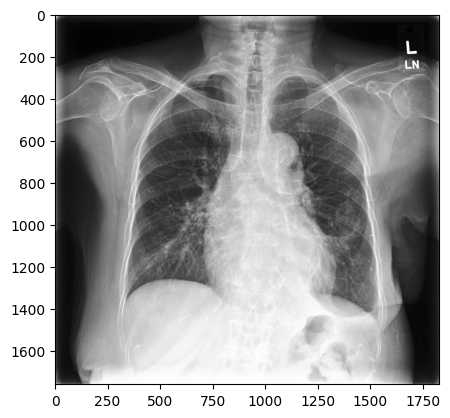

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
import os

def generate_report(image_path, trainer, val_impression, temperature_range=(0.5, 1.5), deterministic=False):
    """
    Generates a report with the image and a caption for the given image path.
    
    Parameters:
    - image_path: Path to the image
    - trainer: The trained model used for caption generation
    - val_impression: The actual caption for the image
    - temperature_range: Range for random temperature during caption generation
    - deterministic: Whether to use deterministic caption generation or not
    """

    # Load the image using PIL
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Display the image
    plt.imshow(image)
    
    # Generate a random temperature for diversity in the caption
    t = np.random.uniform(*temperature_range)

    # Save the image temporarily for caption generation (model expects a path)
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as tmpfile:
        temp_image_path = tmpfile.name
        image.save(temp_image_path)

        # Generate the caption using the model
        try:
            generated_caption = trainer.generate_radiology_report(temp_image_path, temperature=t, deterministic=deterministic)
        except Exception as e:
            print(f"Error generating caption: {e}")
            os.remove(temp_image_path)
            return

        # Optionally delete the temporary file after use
        os.remove(temp_image_path)


    # Return the captions and image path for further use
    return generated_caption, image_path

# Example usage
# Assuming `trainer`, `val_impression` are pre-defined, and `image_path` is the image you want to generate a report for:
image_path = "/kaggle/input/nlp-png/PNG/valid/patient64619/study1/view1_frontal.png"  # Replace with your image path
generated_caption, image_path = generate_report(image_path, trainer, val_impression)

print(f"Report for image: {image_path}")
print(f"Generated readiology report : {generated_caption}")

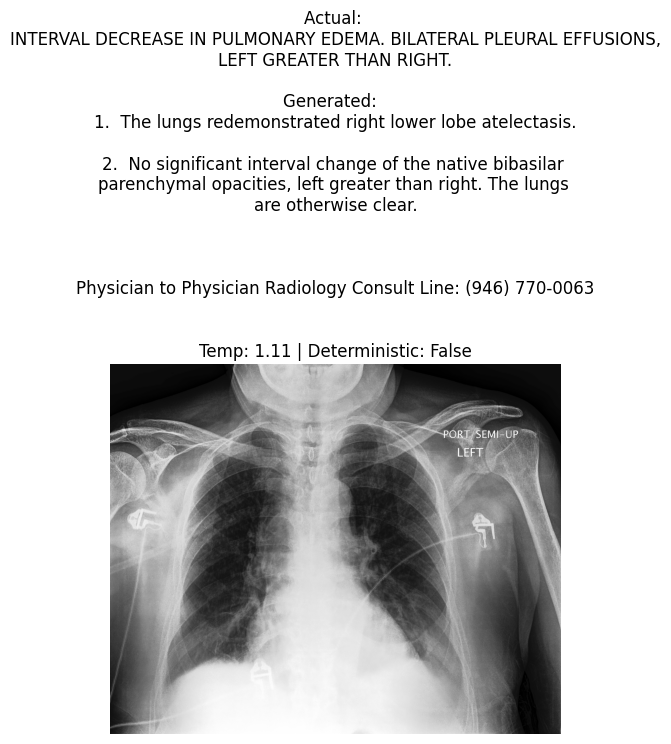

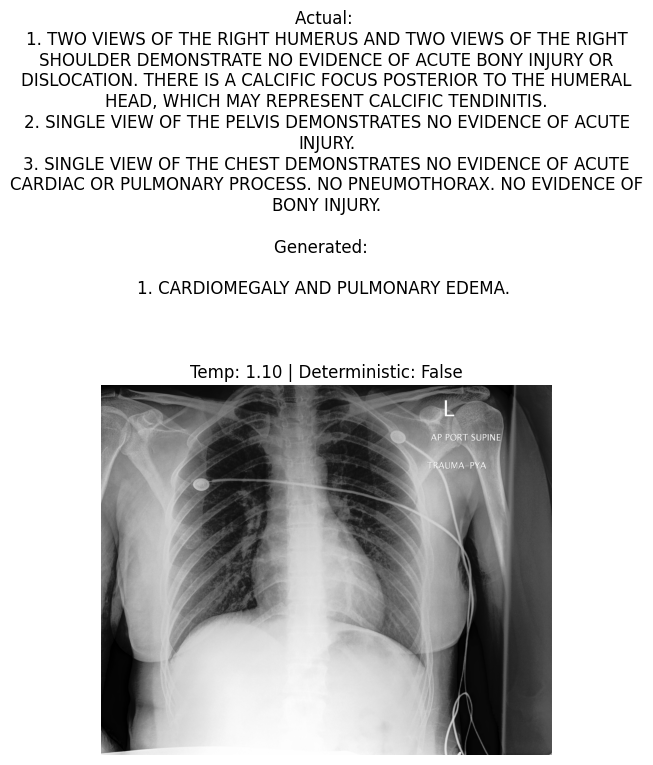

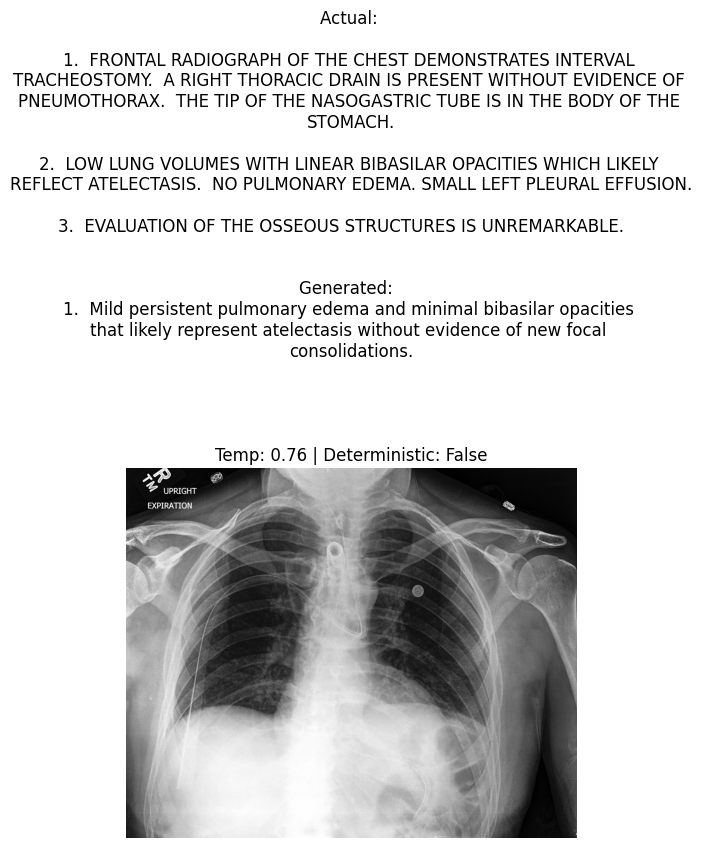

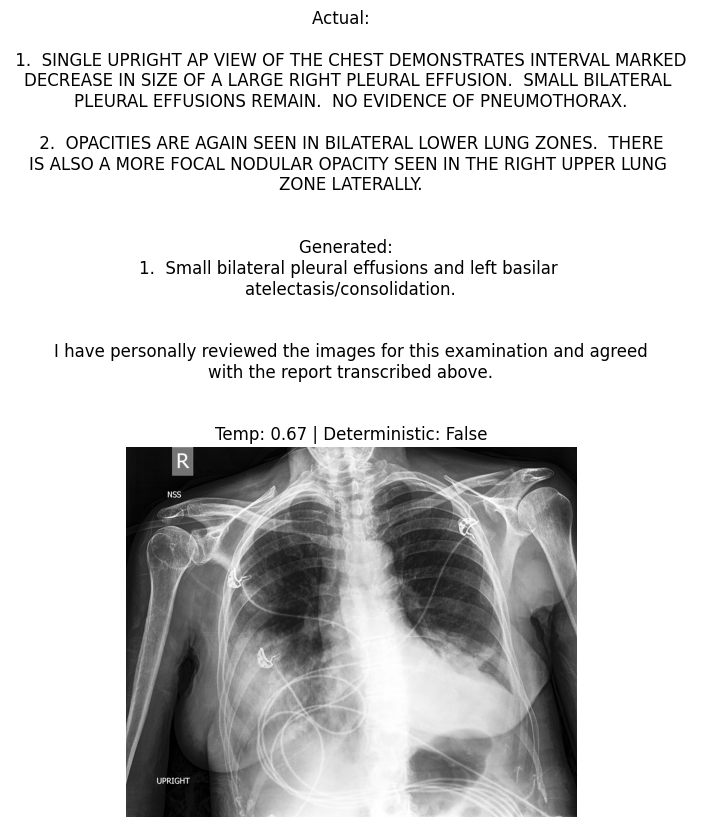

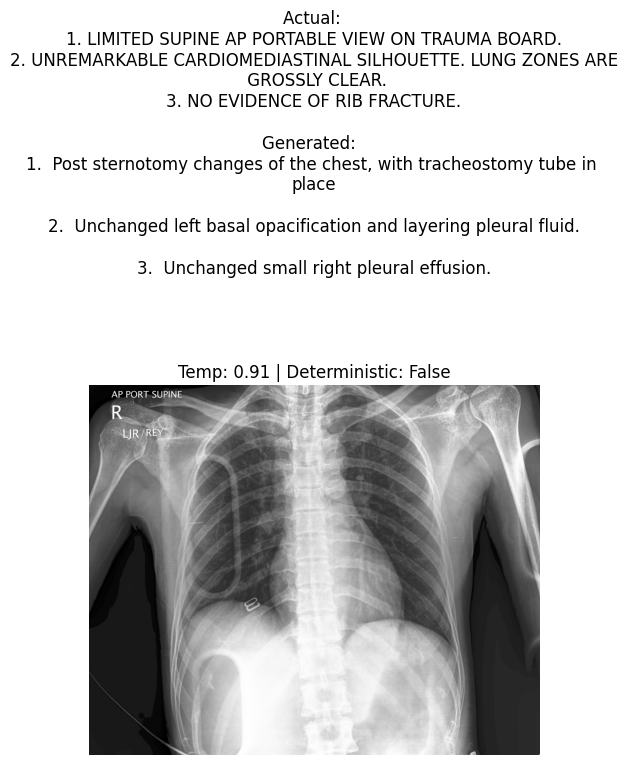

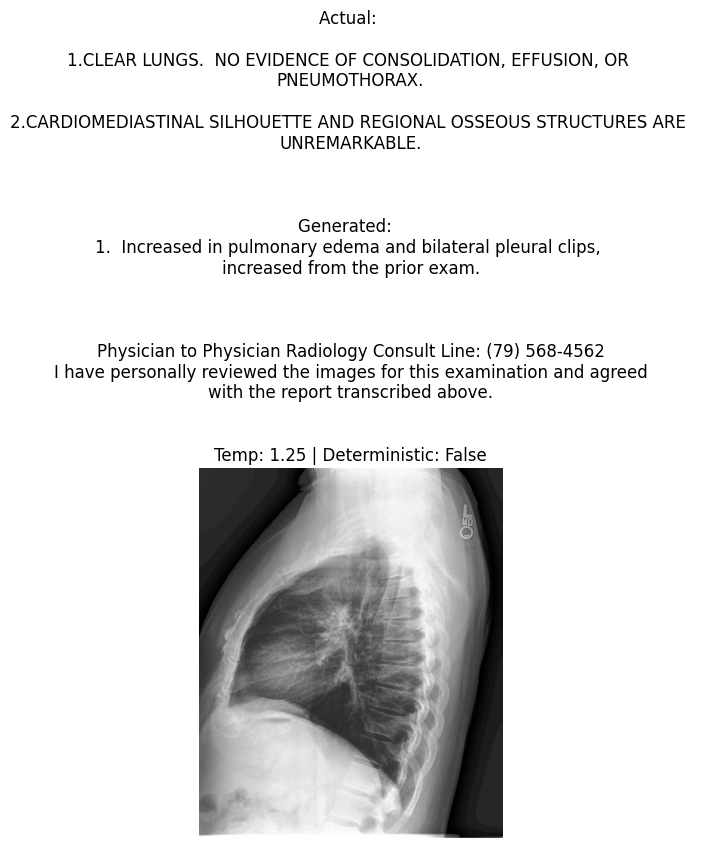

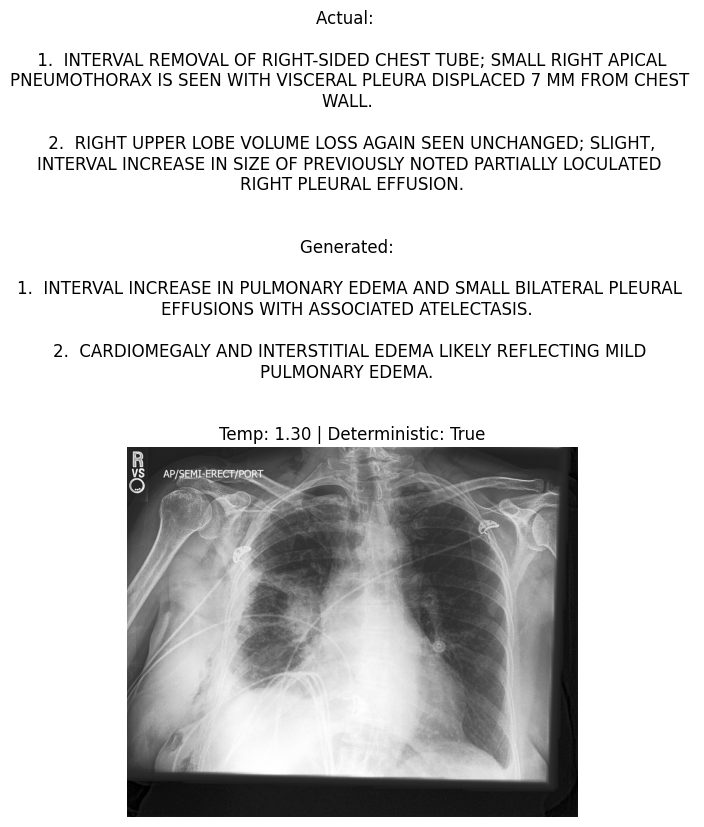

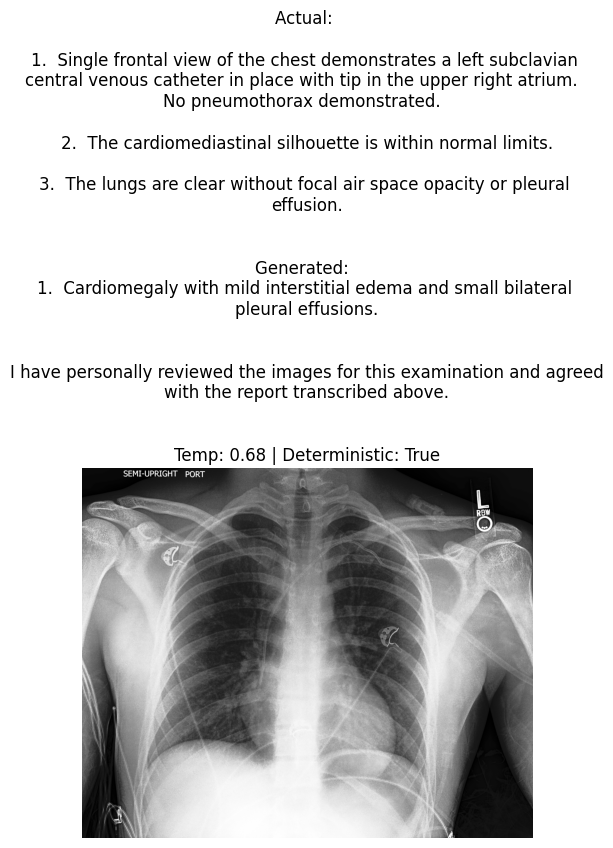

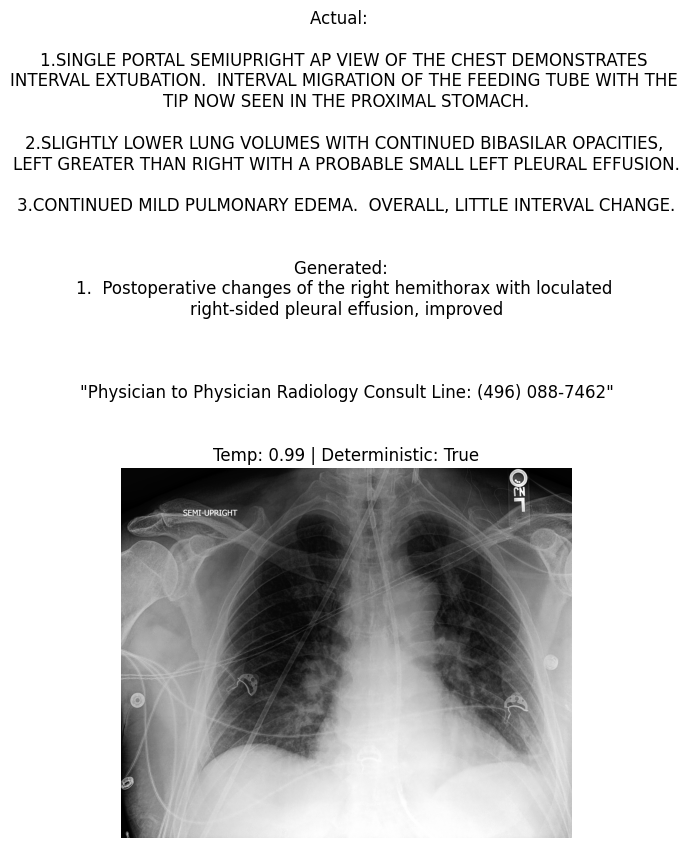

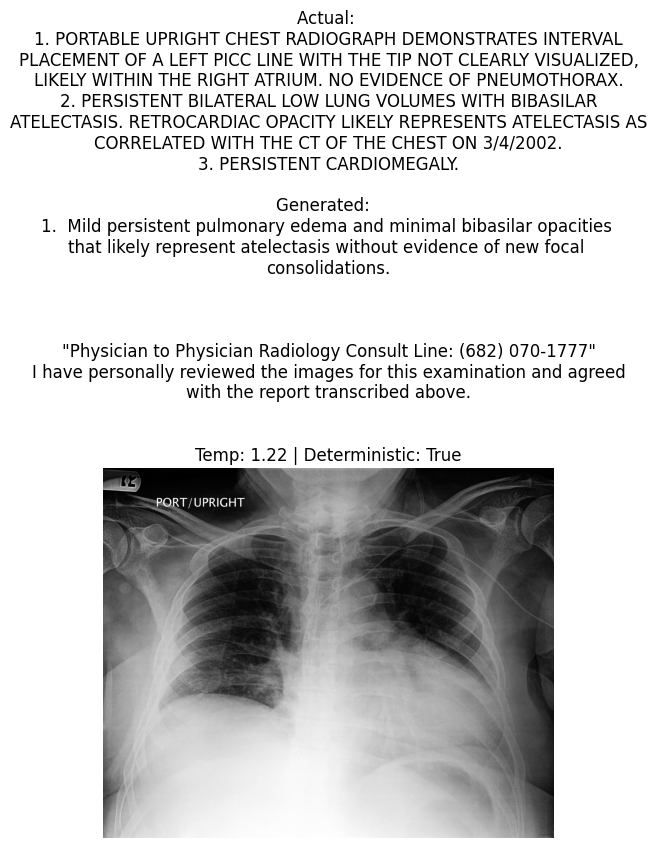

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the CSV file
csv_path = '/kaggle/input/radiology-report-generation-dataset-for-chest-xray/png_labels_narratives.csv'  # Replace with your actual CSV file path
data_df = pd.read_csv(csv_path)

# Loop to process and display 50 randomly selected images
for i in range(10):
    det = False
    
    # Randomly sample one row from data_df and extract filepath and impression
    sample = data_df.sample(n=1).iloc[0]
    test_img_path = sample['png_path']  # Column name for image path
    test_impression = sample['impression']  # Column name for impression (actual caption)
    
    # Display the image
    plt.imshow(Image.open(test_img_path).convert('RGB'))
    
    # Set temperature for caption generation
    t = np.random.uniform(0.5, 1.5)
    
    # Use deterministic caption generation for the last 10 images
    if i > 5:
        det = True
    
    # Generate a caption using the trainer's model
    gen_caption = trainer.generate_radiology_report(test_img_path, temperature=t, deterministic=det)
    
    # Display the image with actual and generated captions
    plt.title(f"Actual: {test_impression}\nGenerated: {gen_caption}\nTemp: {t:.2f} | Deterministic: {det}")
    plt.axis('off')  # Hide axis for a cleaner look
    plt.show()

In [26]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2915741f4f4513ad6c47b8ec1015f4d89a187082a1a177533558705dfba68e40
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from tqdm import tqdm  # For a progress bar

# Load the CSV file
csv_path = '/kaggle/input/radiology-report-generation-dataset-for-chest-xray/png_labels_narratives.csv'  # Replace with your actual CSV file path
data_df = pd.read_csv(csv_path)

# Sample 10,000 rows from the dataset
sample_df = data_df.sample(n=100, random_state=42).reset_index(drop=True)

# Initialize the metric scorers
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store individual scores
results = []

# Process the 10,000 sample dataset
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Processing 10,000 sample dataset"):
    test_img_path = row['png_path']  # Column name for image path
    test_impression = row['impression']  # Column name for impression (actual caption)
    
    # Generate a caption using the trainer's model
    gen_caption = trainer.generate_caption(test_img_path, temperature=1.0, deterministic=True)
    
    # Calculate BLEU score
    bleu = sentence_bleu([test_impression.split()], gen_caption.split())
    
    # Calculate ROUGE scores
    rouge = rouge_scorer.score(test_impression, gen_caption)
    rouge1 = rouge['rouge1'].fmeasure
    rouge2 = rouge['rouge2'].fmeasure
    rougeL = rouge['rougeL'].fmeasure

    # Append results for this image
    results.append({
        "BLEU": bleu,
        "ROUGE-1": rouge1,
        "ROUGE-2": rouge2,
        "ROUGE-L": rougeL
    })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Calculate the average scores for each metric
average_scores = {
    "BLEU": results_df["BLEU"].mean(),
    "ROUGE-1": results_df["ROUGE-1"].mean(),
    "ROUGE-2": results_df["ROUGE-2"].mean(),
    "ROUGE-L": results_df["ROUGE-L"].mean()
}

# Display the final table with average scores
print("\nFinal Metrics for 100 Sample Dataset:")
print(pd.DataFrame([average_scores]))

In [28]:
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm  # For a progress bar

# Function to calculate token-level precision, recall, and F1-score
def calculate_token_metrics(reference, generated):
    ref_tokens = word_tokenize(reference.lower())
    gen_tokens = word_tokenize(generated.lower())
    
    ref_counter = Counter(ref_tokens)
    gen_counter = Counter(gen_tokens)
    
    # Intersection of tokens
    intersection = sum((ref_counter & gen_counter).values())
    
    # Precision: Intersection over generated tokens
    precision = intersection / len(gen_tokens) if len(gen_tokens) > 0 else 0.0
    
    # Recall: Intersection over reference tokens
    recall = intersection / len(ref_tokens) if len(ref_tokens) > 0 else 0.0
    
    # F1-Score: Harmonic mean of precision and recall
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

# Load the CSV file
csv_path = '/kaggle/input/radiology-report-generation-dataset-for-chest-xray/png_labels_narratives.csv'  # Replace with your actual CSV file path
data_df = pd.read_csv(csv_path)

# Sample 1,000 rows from the dataset
sample_df = data_df.sample(n=500, random_state=42).reset_index(drop=True)

# Initialize the metric scorers
rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store individual scores
results = []

# Process the dataset
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Processing 1000 sample dataset"):
    test_img_path = row['png_path']  # Column name for image path
    test_impression = row['impression']  # Column name for impression (actual caption)
    
    # Skip invalid entries where test_impression or gen_caption is not a string
    if not isinstance(test_impression, str):
        continue
    
    # Generate a caption using the trainer's model
    gen_caption = trainer.generate_radiology_report(test_img_path, temperature=1.0, deterministic=True)
    
    # Skip invalid generated captions
    if not isinstance(gen_caption, str):
        continue
    
    # Calculate BLEU score
    bleu = sentence_bleu([test_impression.split()], gen_caption.split())
    
    # Calculate ROUGE scores
    rouge = rouge_scorer.score(test_impression, gen_caption)
    rouge1 = rouge['rouge1'].fmeasure
    rouge2 = rouge['rouge2'].fmeasure
    rougeL = rouge['rougeL'].fmeasure
    
    # Calculate token-level metrics
    precision_rouge1, recall_rouge1, fscore_rouge1 = calculate_token_metrics(test_impression, gen_caption)
    
    # Append results for this image
    results.append({
        "BLEU": bleu,
        "ROUGE-1 Precision": precision_rouge1,
        "ROUGE-1 Recall": recall_rouge1,
        "ROUGE-1 F1-Score": fscore_rouge1,
        "ROUGE-2 F1-Score": rouge2,
        "ROUGE-L F1-Score": rougeL
    })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Calculate the average scores for each metric
average_scores = {
    "BLEU": results_df["BLEU"].mean(),
    "ROUGE-1 Precision": results_df["ROUGE-1 Precision"].mean(),
    "ROUGE-1 Recall": results_df["ROUGE-1 Recall"].mean(),
    "ROUGE-1 F1-Score": results_df["ROUGE-1 F1-Score"].mean(),
    "ROUGE-2 F1-Score": results_df["ROUGE-2 F1-Score"].mean(),
    "ROUGE-L F1-Score": results_df["ROUGE-L F1-Score"].mean()
}

# Convert the scores to a DataFrame for better visualization
average_scores_df = pd.DataFrame([average_scores])

# Display the result table
print("\nRadiology Report Generation Evaluation Metrics:")
print(results_df)

# Display the final average scores
print("\nFinal Average Scores:")
print(average_scores_df)

Processing 1000 sample dataset: 100%|██████████| 500/500 [19:33<00:00,  2.35s/it]


Radiology Report Generation Evaluation Metrics:
         BLEU  ROUGE-1 Precision  ROUGE-1 Recall  ROUGE-1 F1-Score  \
0    0.451801           0.196429        0.366667          0.255814   
1    0.000000           0.173913        0.347826          0.231884   
2    0.139037           0.280000        0.159091          0.202899   
3    0.334413           0.250000        0.211538          0.229167   
4    0.464398           0.217391        0.400000          0.281690   
..        ...                ...             ...               ...   
495  0.000000           0.271186        0.533333          0.359551   
496  0.464345           0.394737        0.375000          0.384615   
497  0.152478           0.307692        0.125000          0.177778   
498  0.052577           0.187500        0.057692          0.088235   
499  0.405875           0.423077        0.366667          0.392857   

     ROUGE-2 F1-Score  ROUGE-L F1-Score  
0            0.000000          0.133333  
1            0.000000     

**______________________________________________________________________________________________________**

In [ ]:
import torch
model = RadiologyReportGeneratorCrossAttention()
# Load the model
model = torch.load('/kaggle/working/vit_entire_pretrained_model_test.pth')
model.eval()  # Set the model to evaluation mode if you're using it for inference

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Define the image path
image_path = '/kaggle/input/nlp-png/PNG/train/patient00008/study2/view1_frontal.png'  # Replace with your actual image path

# Define a transformation to preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the expected input size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (adjust if necessary for your model)
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension

# Initialize the model
# model = RadiologyReportGenerator()

# Generate a report
results = model.generate_report(
    pixel_values=image_tensor,
    max_length=500,
    temperature=0.9,  # Adjust for creativity vs. accuracy
    top_p=0.9,        # Nucleus sampling parameter
    repetition_penalty=5.0  # Prevent repetitive text
)

# Access the generated report and attention weights
report = results['generated_text']
attention_weights = results['attention_weights']

# Display the report
print("Generated Report:", report)

In [ ]:
import torch

# Define the path where you want to save the model
save_path = '/kaggle/working/vit_pretrained_model_test.pth'

# Save the model's state_dict (recommended method)
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

In [ ]:
# Initialize the model architecture (this should match the model you saved)
model = YourModelClass(*args)

# Load the saved state_dict into the model
model.load_state_dict(torch.load(save_path))

# Move the model to the desired device (GPU or CPU)
model.to(device)

print("Model loaded successfully.")

In [ ]:
# Save the entire model (not just the state_dict)
torch.save(model, '/kaggle/working/vit_entire_pretrained_model_test.pth')


In [ ]:
import os
from IPython.display import FileLink

def create_download_link(directory=os.curdir, file_name='vit_pretrained_model_vfinal.pth'):
    # Change to the specified directory
    os.chdir(directory)
    
    # Check if the file exists
    if os.path.exists(file_name):
        # Create a download link
        return FileLink(file_name)
    else:
        return "File does not exist."

# Call the function
create_download_link()

In [ ]:

gc.collect()
torch.cuda.empty_cache()